# Pairs Selection using CCM/KNN for Statistical Arbitrage

This notebook documents the steps taken to identify cointegrated pairs using **Convergent Cross Mapping (CCM)** and **K-Nearest Neighbors (KNN)** based similarity, with the goal of implementing a pairs trading strategy.

## Step 1: Load and Preprocess Price Data

In this step, we load historical price data for tech stocks from the SP500 from September 2024 to April 2025 to prepare it for cointegration and nonlinear similarity analysis.

We typically use daily closing prices, as they are sufficient to capture medium-term relationships between assets in a pairs trading context.

The output of this step is a clean time series dataset, where each column represents a stock and each row represents a trading day.

In [2]:
import pandas as pd
import numpy as np

# Data loaded using data.py and cleaned using clean.py

df = pd.read_csv("data/clean/train_prices_clean.csv", index_col=0, parse_dates=True)
df.head()

,AAPL,ACN,ADBE,ADI,ADSK,AMAT,AMD,ANET,ANSS,APH,...,ORCL,PANW,PLTR,QCOM,ROP,SNPS,TEL,TXN,VRSN,WDAY
Date,,,,,,,,,,,,,,,,,,,,,
2023-11-22,189.919205,324.861176,619.719971,178.006088,202.660004,147.980957,122.510002,54.422501,298.519989,44.453617,...,114.144081,131.570007,19.690001,123.577789,523.968506,541.030029,128.566483,147.310410,214.160004,234.259995
2023-11-24,188.588928,325.748596,619.429993,178.376404,203.419998,148.832306,122.309998,54.597500,297.899994,44.586845,...,114.153908,133.039993,19.200001,123.820099,521.103210,542.690002,128.302139,146.985046,213.229996,236.610001
2023-11-27,188.410248,324.178558,619.270020,179.078003,202.259995,149.297607,122.650002,54.667500,297.230011,44.468422,...,114.369942,134.544998,19.080000,124.256264,520.518311,543.530029,127.900795,146.037613,213.960007,235.830002
2023-11-28,189.015808,324.305328,623.320007,178.522552,207.369995,146.575180,122.010002,54.312500,294.619995,44.364803,...,114.144081,138.914993,19.709999,122.695793,521.380798,543.729980,127.450462,146.324707,213.490005,237.330002
2023-11-29,187.993317,325.065918,617.390015,178.045090,213.850006,147.862152,123.849998,54.825001,298.859985,44.498028,...,114.114616,144.455002,19.840000,124.763649,521.341187,552.460022,127.685402,146.611801,211.699997,263.489990


## Step 2: Cointegration scan using Engle-granger test

The goal here is to identify pairs of assets that are **cointegrated**. This means their prices move together over time in a stable long-term relationship, despite being non-stationary individually.

We use the **Engle-Granger test**, which works as follows:
1. Run a linear regression of one asset on another to estimate the hedge ratio (β).
2. Test the residuals of that regression for stationarity using a **unit root test** (Augmented Dickey-Fuller).

If the residuals are stationary (i.e., reject the null hypothesis of a unit root), the two assets are considered **cointegrated**.

This gives us a first list of candidate pairs that might be suitable for pairs trading based on mean-reverting spread behavior.

In [3]:
from cointegration import scan_pairs
import itertools
import itertools as it
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from cointegration import scan_pairs, eagle_granger_test

pairs = scan_pairs(df, p=0.05)
if not pairs:
    print("No cointegrated pairs found in training data at p < 0.05")
else:
    out_df = pd.DataFrame(pairs, columns=["stock1","stock2","pvalue"])
    print(f"Found {len(pairs)} cointegrated pairs in training data")
    print("Training Pairs:")
    print(out_df)

Found 207 cointegrated pairs in training data
Training Pairs:
    stock1 stock2    pvalue
0     AAPL    AMD  0.044610
1     AAPL   ANSS  0.010670
2     AAPL    GLW  0.049336
3     AAPL   INTU  0.000424
4     AAPL   PANW  0.002290
..     ...    ...       ...
202    TEL    TXN  0.028795
203    TEL   VRSN  0.007858
204    TEL   WDAY  0.032346
205    TXN   WDAY  0.019199
206   VRSN   WDAY  0.029409

[207 rows x 3 columns]


## Step 3: Compute the CCM filter to filter the pairs having nonlinear relationships

While cointegration tests capture linear long-term relationships, they can miss nonlinear or lagged dependencies that exist between asset prices.

To capture such complex interactions, we apply **Convergent Cross Mapping (CCM)** — a method from nonlinear dynamical systems theory.

**CCM works by:**
- Creating delay embeddings of time series to reconstruct their state-space behavior.
- Measuring how well the past of one time series can predict the present of another using **K-Nearest Neighbors (KNN)**.
- Evaluating whether prediction skill converges as more data is used — a sign of dynamic coupling.

By applying CCM, we filter the cointegrated pairs and retain only those with strong nonlinear dependencies, giving us higher-quality candidates for pairs trading.

This step helps us go beyond linear statistics and tap into hidden structure that may provide stronger trading signals.

The heatmap of CCM scores provides a visual representation of the cross-mapping skill between asset pairs. By comparing these scores with the cointegration p-values, we can identify the pairs that exhibit both strong nonlinear coupling and statistical cointegration, allowing us to select the most promising candidates for our trading strategy.

In-sample CCM-filtered pairs:
   stock1 stock2      r_xy      r_yx
0    AAPL    GLW  0.907251  0.907250
1    AAPL   PANW  0.807206  0.807204
2     ACN   CTSH  0.871860  0.871862
3     ADI    TEL  0.834277  0.834276
4    ADSK   CTSH  0.832860  0.832861
5    AMAT   NXPI  0.911151  0.911152
6    ANET   AVGO  0.946442  0.946442
7    ANET   GDDY  0.937555  0.937556
8    ANET    GLW  0.953562  0.953561
9     APH   NVDA  0.957147  0.957146
10    APH    TEL  0.865849  0.865850
11   AVGO   GDDY  0.877605  0.877605
12   CSCO   FTNT  0.905697  0.905697
13   FICO     IT  0.863334  0.863333
14   FICO   ORCL  0.962212  0.962213
15   FICO   PANW  0.843188  0.843190
16   FTNT    NOW  0.947408  0.947408
17    GLW    MSI  0.960730  0.960730
18    GLW   ORCL  0.943772  0.943772
19    HPQ    TXN  0.911489  0.911487
20    IBM     IT  0.901304  0.901303
21    MSI   ORCL  0.966776  0.966776
22     MU   QCOM  0.904247  0.904247
23    NOW   PANW  0.828731  0.828730
24    NOW   PLTR  0.959413  0.959413
25   NVD

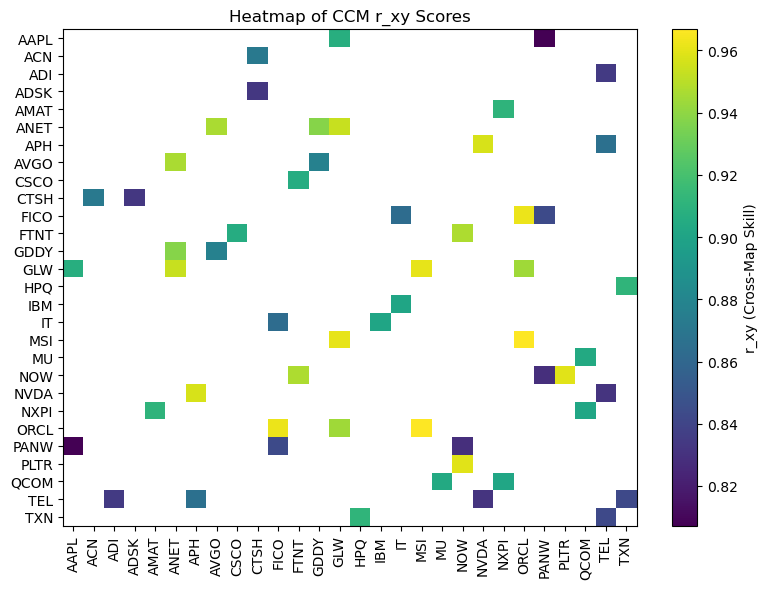

In [5]:
from sklearn.neighbors import NearestNeighbors
from scipy.stats import zscore, pearsonr
from ccm_filter import filter_ccm
import matplotlib.pyplot as plt

pairs = pd.DataFrame(
    pairs,
    columns=["stock1","stock2","pvalue"]
)

# Backtested in train_ccm to find the best embedding dimension E and neighbors k
good = filter_ccm(df, pairs, E=4, tau=1, k=5, r_tresh=0.8)
out = pd.DataFrame(good, columns=["stock1","stock2","r_xy","r_yx"])
print("In-sample CCM-filtered pairs:")
print(out)

import os
out.to_csv("data/processed/universal_pairs.csv", index=False)
print("In-sample CCM-filtered pairs saved")

# Heatmap for visualization

tickers = sorted(set(out['stock1']).union(out['stock2']))
matrix = pd.DataFrame(np.nan, index=tickers, columns=tickers)

for _, row in out.iterrows():
    t1, t2, r_xy, r_yx = row['stock1'], row['stock2'], row['r_xy'], row['r_yx']
    matrix.loc[t1, t2] = r_xy
    matrix.loc[t2, t1] = r_yx  # mirror for symmetry

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(matrix.values, aspect='auto', interpolation='nearest')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('r_xy (Cross-Map Skill)')

ax.set_xticks(range(len(tickers)))
ax.set_yticks(range(len(tickers)))
ax.set_xticklabels(tickers, rotation=90)
ax.set_yticklabels(tickers)
ax.set_title('Heatmap of CCM r_xy Scores')

plt.tight_layout()
plt.show()

## Step 4: Test the filter on pairs from the Testing set

In-sample CCM-filtered pairs:
  stock1 stock2      r_xy      r_yx
0    ACN   CTSH  0.859472  0.859473
1    ADI    TEL  0.856171  0.856171
2   ANET   AVGO  0.921263  0.921264
3   ANET   GDDY  0.838560  0.838560
4   ANET    GLW  0.859519  0.859519
5    GLW   ORCL  0.955634  0.955634
6    HPQ    TXN  0.874212  0.874213
7     MU   QCOM  0.823543  0.823544
8   NXPI   QCOM  0.863582  0.863583


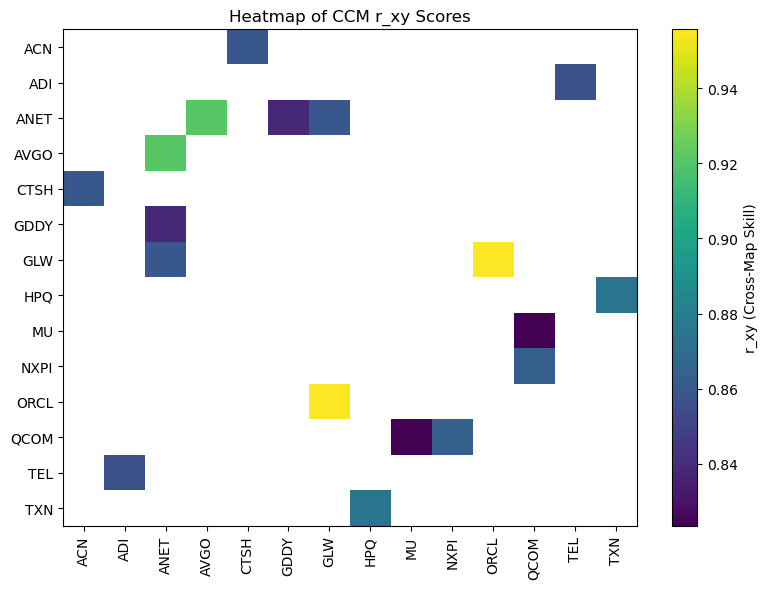

In [6]:
# Load testing data
df_test = pd.read_csv("data/clean/test_prices_clean.csv", index_col=0, parse_dates=True)
df_test.head()

pairs = out
good = filter_ccm(df_test, out, E=4, tau=1, k=5, r_tresh=0.8)
out = pd.DataFrame(good, columns=["stock1","stock2","r_xy","r_yx"])
print("In-sample CCM-filtered pairs:")
print(out)

# Heatmap for visualization

tickers = sorted(set(out['stock1']).union(out['stock2']))
matrix = pd.DataFrame(np.nan, index=tickers, columns=tickers)

for _, row in out.iterrows():
    t1, t2, r_xy, r_yx = row['stock1'], row['stock2'], row['r_xy'], row['r_yx']
    matrix.loc[t1, t2] = r_xy
    matrix.loc[t2, t1] = r_yx  # mirror for symmetry

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(matrix.values, aspect='auto', interpolation='nearest')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('r_xy (Cross-Map Skill)')

ax.set_xticks(range(len(tickers)))
ax.set_yticks(range(len(tickers)))
ax.set_xticklabels(tickers, rotation=90)
ax.set_yticklabels(tickers)
ax.set_title('Heatmap of CCM r_xy Scores')

plt.tight_layout()
plt.show()

## Results of the test

Survival rate: 9/28 = 32.1%


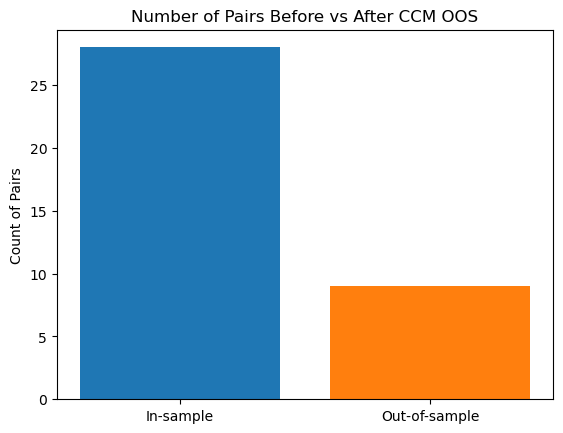

In [7]:
import matplotlib.pyplot as plt

N_train = len(out_tr)
N_test  = len(out)

retention_rate = N_test / N_train * 100
print(f"Survival rate: {N_test}/{N_train} = {retention_rate:.1f}%")

plt.bar(["In-sample","Out-of-sample"], [N_train, N_test], color=["C0","C1"])
plt.title("Number of Pairs Before vs After CCM OOS")
plt.ylabel("Count of Pairs")
plt.show()

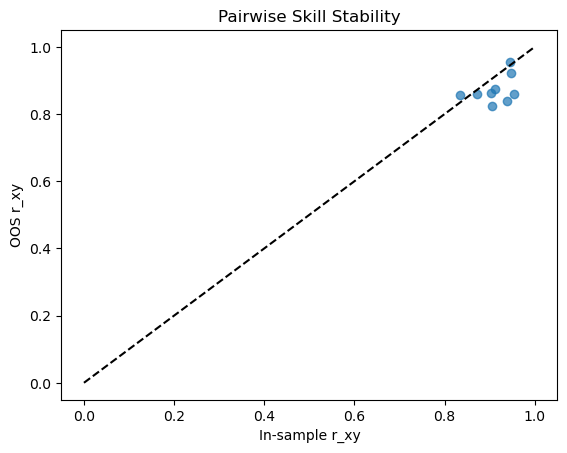

In [8]:
merged = pd.merge(
    pairs.assign(pair=pairs.stock1+"-"+pairs.stock2),
    out.assign(pair=out.stock1 + "-" + out.stock2),
    on="pair", suffixes=("_train","_test")
)

plt.scatter(merged["r_xy_train"], merged["r_xy_test"], alpha=0.7)
plt.plot([0,1],[0,1], "k--")
plt.xlabel("In-sample r_xy")
plt.ylabel("OOS r_xy")
plt.title("Pairwise Skill Stability")
plt.show()

Odd that a lot of pairs have a higher score, is it a fluke?

In [9]:
import os

out.to_csv("data/processed/universal_pairs_t.csv", index=False)
print("In-sample CCM-filtered pairs saved")

In-sample CCM-filtered pairs saved


## Step 5: ML Model & Strategy Overview

### 1. Hedge‐ratio estimation (OLS spread construction)
We first estimate the long-run relationship between each pair \(A,B\) by running an OLS regression

### 2. Normalizing with a z-score
To turn the raw spread into a stationary, mean-zero process, we compute the rolling zscore over a 60-day window.

### 3. Feature engineering
We feed the model 4 features at time \(t\):
- **`lag1`, `lag2`**: yesterday’s and two-days-ago z-scores
- **`momentum`**: (5-day change)
- **`volatility`**: 10-day rolling standard deviation of the spread

### 5. Model choice: Random Forest
We train a RandomForestClassifier() on these features and labels.
This non-parametric ensemble: handles nonlinear interactions gives us feature‐importance insights

### 6. Generating trading signals
Once we have a forecast \(\hat{p}_t \in \{0,1\}\), we only act when the model predicts reversion (`predicted == 1`) and the current z-score has diverged sufficiently:

- If \(z_t > +1\) → **short** the spread (signal = –1)
- If \(z_t < -1\) → **long** the spread (signal = +1)
- Otherwise → **flat** (signal = 0)

### 7. Backtest & Risk Controls

Compute per-bar PnL as:

\[
\text{PnL}_t = \text{signal}_t \times (\varepsilon_{t+1} - \varepsilon_t)
\]

(net of transaction costs and an optional stop-loss), then derive:

- **Equity curve**: \(\sum_t \text{PnL}_t\)
- **Daily returns**: \(\text{PnL}_t\)
- **Annualized Sharpe**, **win/loss ratio**, **max drawdown**, etc.

Top 5 Pairs:
           sharpe  wl_ratio  num_trades  max_drawdown
pair                                                 
TEL-TXN     3.425      0.88          36         -0.88
ANET-AVGO   3.408      1.05          35         -0.18
MU-QCOM     3.139      1.08          21         -0.44
ADI-TEL     2.431      0.58          27         -0.38
GLW-MSI     2.140      0.93          43         -3.39


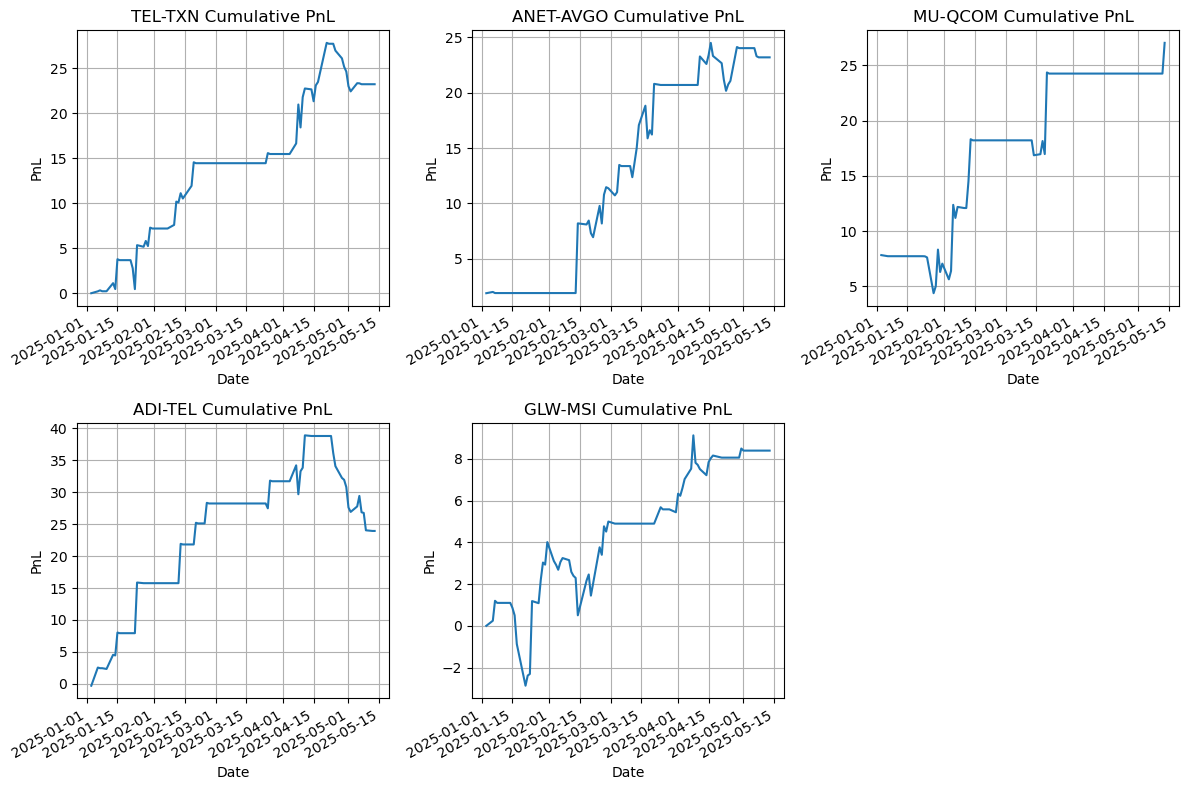

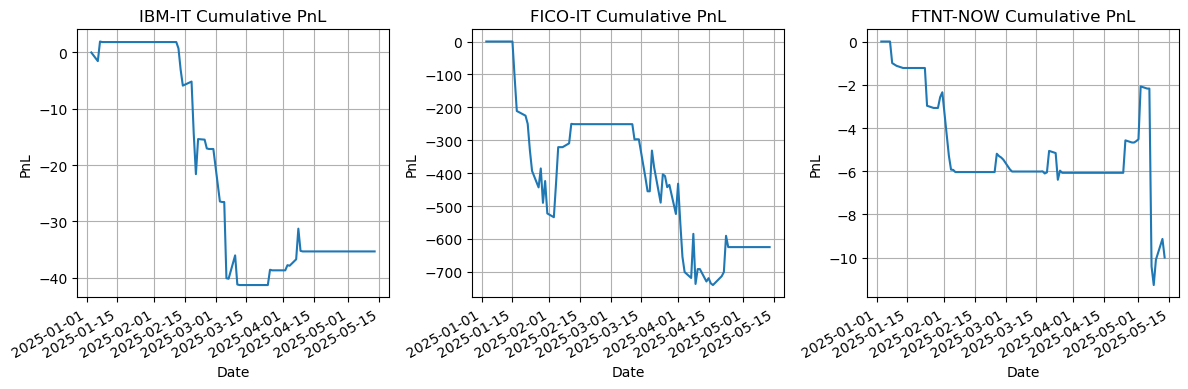

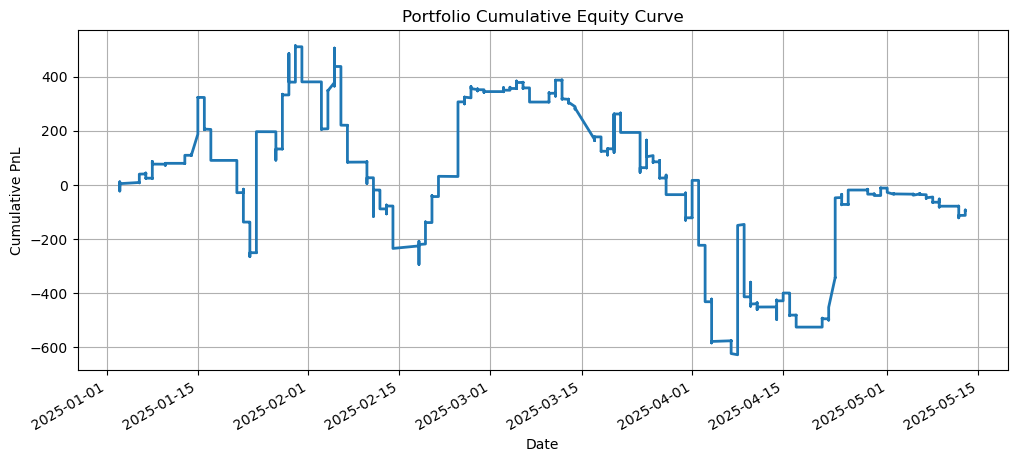

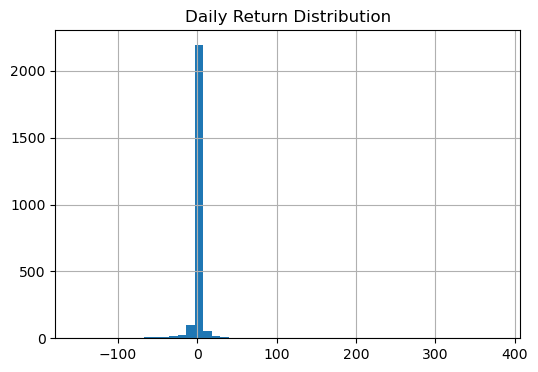

In [17]:
# Load your summary metrics

summary = pd.read_csv("results/backtest_summary.csv", index_col=0)
top5 = summary.sort_values("sharpe", ascending=False).head(5)
worst3 = summary.sort_values("sharpe", ascending=True).head(3)
initial_capital = 10_000

print("Top 5 Pairs:")
print(top5)

# Plot each of the top 5 equity curves
import math

pairs = top5.index.tolist()

n = len(pairs)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, 8), sharex=False)
axes_flat = axes.flatten()

for ax, pair in zip(axes_flat, pairs):
    pnl = (
        pd.read_csv(f"results/dailyret-{pair}.csv", index_col=0, parse_dates=True)
          .squeeze()
          .cumsum()
    )
    pnl.plot(ax=ax, title=f"{pair} Cumulative PnL")
    ax.set_ylabel("PnL")
    ax.grid(True)

for ax in axes_flat[n:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

# Plot worst 3 equity curves
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=False)

for ax, pair in zip(axes, worst3.index):
    pnl = (
        pd.read_csv(f"results/dailyret-{pair}.csv", index_col=0, parse_dates=True)
          .squeeze()
          .cumsum()
    )
    pnl.plot(ax=ax, title=f"{pair} Cumulative PnL")
    ax.set_ylabel("PnL")
    ax.grid(True)

# 3) Turn off any extra subplot (there won’t be any here, but good practice)
for ax in axes[len(worst3):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

# Equity curve of Portfolio

all_returns = pd.concat(
    pd.read_csv(f"results/dailyret-{p}.csv", index_col=0, parse_dates=True).squeeze()
    for p in summary.index
).sort_index()

cum_equity = all_returns.cumsum()

plt.figure(figsize=(12,5))
cum_equity.plot(title="Portfolio Cumulative Equity Curve", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Cumulative PnL")
plt.grid(True)
plt.show()

# 6) Return distribution
plt.figure(figsize=(6,4))
all_returns.hist(bins=50)
plt.title("Daily Return Distribution")
plt.show()

In [25]:
mu = all_returns.mean()
sigma = all_returns.std()
print(f"Mean: {mu:.5f}  Std: {sigma:.5f}")

Mean: -0.03743  Std: 17.50343


[*********************100%***********************]  1 of 1 completed
C:\Users\uqfdelor\AppData\Local\Temp\ipykernel_26764\584504885.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="ffill"))


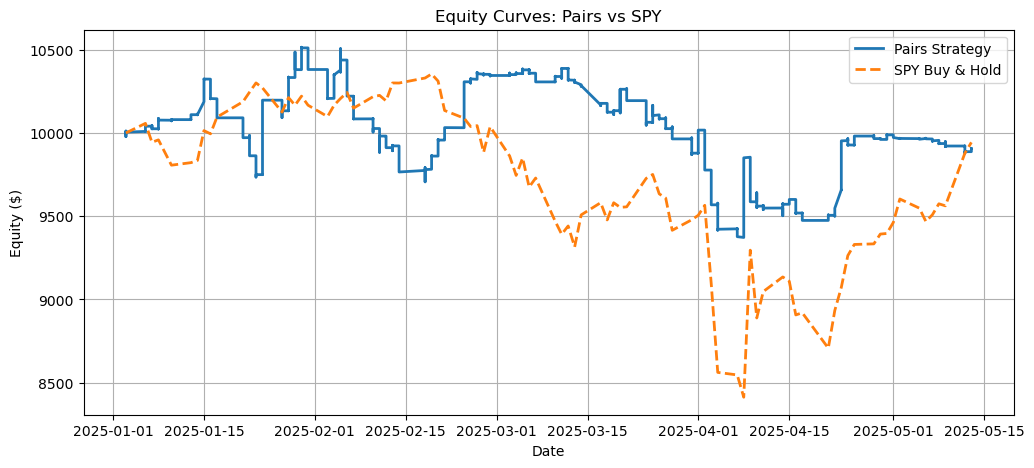

In [31]:
# Pairs vs SPY
import yfinance as yf
import numpy as np

# -- portfolio equity
portfolio_daily = all_returns         # your net daily PnL series
equity_pairs    = initial_capital + portfolio_daily.cumsum()

# -- SPY buy‐and‐hold
start, end = equity_pairs.index[[0, -1]]
spy = (yf.download("SPY", start=start, end=end)["Close"]
         .fillna(method="ffill"))
spy_equity = initial_capital * (spy / spy.iloc[0])

fig, ax = plt.subplots(figsize=(12,5))

ax.plot(equity_pairs.index, equity_pairs.values,
        label="Pairs Strategy", linewidth=2)
ax.plot(spy_equity.index,  spy_equity.values,
        linestyle="--", label="SPY Buy & Hold", linewidth=2)


ax.set_title("Equity Curves: Pairs vs SPY")
ax.set_xlabel("Date")
ax.set_ylabel("Equity ($)")
ax.legend()
ax.grid(True)

plt.show()

## Step 6: Results & Performance Analysis

### 1. Portfolio Cumulative PnL & Return Distribution

The **portfolio equity curve** shows modest gains initially, followed by a volatile drawdown phase, and partial recovery. While the strategy exhibits some profitable streaks, it also suffers large fluctuations.

- The **mean daily return** is slightly negative at \(-0.037\), with a **high volatility** (standard deviation ≈ 17.5), as shown in the histogram.
- The **return distribution** is highly leptokurtic (fat tails), with a large concentration of near-zero returns and occasional extreme outcomes.

### 2. Best and Worst Performing Pairs

- **Top 5 pairs** (e.g. `TEL-TXN`, `ANET-AVGO`, `MU-QCOM`) exhibit consistent upward trends with low drawdown and clean execution.
  These pairs produce the majority of the strategy’s positive returns.

- **Worst pairs** like `FICO-IT`, `IBM-IT` show steep, sustained losses and failed reversions — likely from structural break or poor ML signal reliability.

This highlights the **importance of robust pair selection** and out-of-sample validation, if pairs were chosen more carefully (for example top 5 pairs with the highest trading signals), results could have varied greatly as the top pairs have quite a high sharpe ratio, and worst pairs are really underperforming.

### 3. Equity Curve vs SPY Benchmark

Compared to a **SPY buy-and-hold** strategy:
- The pairs trading equity curve is **less smooth and more volatile**, reflecting its mean-reversion nature.
- It fails to outperform SPY over the test period, especially in the drawdown phase during mid-March to April.

This suggests that while the ML model may generate good signals in some regimes, it can underperform in **trending markets** where mean-reversion breaks down.

### 4. Strategy Characteristics

- The **top-performing pairs** have high Sharpe ratios (> 2.0), with low drawdowns.
- The **portfolio suffers** from a few poor pairs dragging down the cumulative equity, which is visible in the drawdown structure.

---

### Summary:

- **Strengths**:
  - Some ML-selected pairs clearly produce alpha.
  - The strategy adapts using feature-based reversion signals.

- **Weaknesses**:
  - Equity curve suggests lack of robustness across all selected pairs.
  - Portfolio-level return distribution has high volatility and negative average return.

Overall, this simple strategy isn't beating the market which makes sense.